# Time Series Classification

In [1]:
import pandas as pd
import numpy as np
import os
import statistics as stat
import random
import seaborn as sns
from sklearn import datasets
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import statsmodels.discrete.discrete_model as sm
from sklearn.utils import resample
from itertools import cycle
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

Duplicate key in file PosixPath('/Users/fanyingning/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 259 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/Users/fanyingning/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 402 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


(a) Download the AReM data

In [2]:
os.chdir('../data/AReM')

In [3]:
data_hw3 = {}
folder = ['bending1','bending2','cycling','lying','sitting','standing','walking']
df_name = ['time','avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
for i in folder:
    file = os.listdir(i)
    for j in file:
        if i=='bending2' and j=='dataset4.csv':
            data_hw3[i+j] = pd.read_csv(i+"/"+j, skiprows=5, names=df_name,sep=' ')
        else:
            data_hw3[i+j] = pd.read_csv(i+"/"+j, skiprows=5, names=df_name)
data_hw3
    #print(file)
#df = pd.read_excel('../data/CCPP/Folds5x2_pp.xlsx',names=['AT','V','AP','RH','EP'],sheet_name='Sheet1')

{'bending1dataset7.csv':        time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
 0         0      42.00       0.00      18.50       0.50      12.00       0.00
 1       250      42.00       0.00      18.00       0.00      11.33       0.94
 2       500      42.75       0.43      16.75       1.79      18.25       0.43
 3       750      42.50       0.50      16.75       0.83      19.00       1.22
 4      1000      43.00       0.82      16.25       0.83      18.00       0.00
 ..      ...        ...        ...        ...        ...        ...        ...
 475  118750      44.25       0.83      16.25       1.30      24.00       0.00
 476  119000      44.00       0.71      11.00       1.00      24.00       0.00
 477  119250      44.25       0.43      10.25       1.30      22.75       0.83
 478  119500      43.75       0.43       7.33       2.87      21.50       0.50
 479  119750      44.50       0.50       3.00       1.22      21.50       0.50
 
 [480 rows x 7 columns],
 

(b)Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 
in other folders as test data and other datasets as train data.

In [4]:
test_data = {}
train_data = {}
test_pre = ['bending1dataset1.csv','bending1dataset2.csv','bending2dataset1.csv','bending2dataset2.csv',
            'cyclingdataset1.csv','cyclingdataset2.csv','cyclingdataset3.csv',
            'lyingdataset1.csv','lyingdataset2.csv','lyingdataset3.csv',
           'sittingdataset1.csv','sittingdataset2.csv','sittingdataset3.csv',
           'standingdataset1.csv','standingdataset2.csv','standingdataset3.csv',
           'walkingdataset1.csv','walkingdataset2.csv','walkingdataset3.csv']

for i, j in data_hw3.items():
    if i in test_pre:
        test_data[i] = j
    else:
        train_data[i] = j

In [5]:
test_data

{'bending1dataset1.csv':        time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
 0         0      39.25       0.43      22.75       0.43      33.75        1.3
 1       250      39.25       0.43      23.00       0.00      33.00        0.0
 2       500      39.25       0.43      23.25       0.43      33.00        0.0
 3       750      39.50       0.50      23.00       0.71      33.00        0.0
 4      1000      39.50       0.50      24.00       0.00      33.00        0.0
 ..      ...        ...        ...        ...        ...        ...        ...
 475  118750      43.33       0.47      25.00       0.00      30.00        0.0
 476  119000      43.50       0.50      25.50       0.50      30.00        0.0
 477  119250      43.50       0.50      24.75       0.43      30.00        0.0
 478  119500      43.50       0.50      24.33       0.47      30.00        0.0
 479  119750      43.50       0.50      24.25       0.43      30.00        0.0
 
 [480 rows x 7 columns],
 

In [6]:
train_data

{'bending1dataset7.csv':        time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
 0         0      42.00       0.00      18.50       0.50      12.00       0.00
 1       250      42.00       0.00      18.00       0.00      11.33       0.94
 2       500      42.75       0.43      16.75       1.79      18.25       0.43
 3       750      42.50       0.50      16.75       0.83      19.00       1.22
 4      1000      43.00       0.82      16.25       0.83      18.00       0.00
 ..      ...        ...        ...        ...        ...        ...        ...
 475  118750      44.25       0.83      16.25       1.30      24.00       0.00
 476  119000      44.00       0.71      11.00       1.00      24.00       0.00
 477  119250      44.25       0.43      10.25       1.30      22.75       0.83
 478  119500      43.75       0.43       7.33       2.87      21.50       0.50
 479  119750      44.50       0.50       3.00       1.22      21.50       0.50
 
 [480 rows x 7 columns],
 

# (c) Feature Extraction

i. Research what types of time-domain features are usually used in time series classification 
and list them (examples are minimum, maximum, mean, etc).

minimum, maximum, mean, Standard deviations, Skewness, Kurtosis, median

ii. Extract the time-domain features minimum, maximum, mean, median, stan-
dard deviation, first quartile, and third quartile for all of the 6 time series
in each instance. You are free to normalize/standardize features or use them

In [7]:
a = data_hw3.values()
a = list(a)
#print(a)
instance = []
var = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
for i in range(0,88,1):
    number = []
    name = []
    k = 1
    for j in var:
        mini = min(a[i][j])
        maxi = max(a[i][j])
        mean = stat.mean(a[i][j])
        median = stat.median(a[i][j])
        sd = a[i][j].std()
        first = a[i][j].quantile(0.25)
        third = a[i][j].quantile(0.75)
        number.append(mini)
        number.append(maxi)
        number.append(mean)
        number.append(median)
        number.append(sd)
        number.append(first)
        number.append(third)
        name.append("min_" + j)
        name.append("max_"+ j)
        name.append("mean_" + j)
        name.append("median_"+ j)
        name.append("Sta_Dev_"+ j)
        name.append("1_quart_"+ j)
        name.append("3_quart_"+ j)
        k = k + 1
    instance.append(number)
inst_total = pd.DataFrame(instance,columns=name)
inst_total

,min_avg_rss12,max_avg_rss12,mean_avg_rss12,median_avg_rss12,Sta_Dev_avg_rss12,1_quart_avg_rss12,3_quart_avg_rss12,min_var_rss12,max_var_rss12,mean_var_rss12,...,Sta_Dev_avg_rss23,1_quart_avg_rss23,3_quart_avg_rss23,min_var_rss23,max_var_rss23,mean_var_rss23,median_var_rss23,Sta_Dev_var_rss23,1_quart_var_rss23,3_quart_var_rss23
0,36.25,48.00,43.969125,44.500,1.618364,43.31,44.67,0.0,1.50,0.413125,...,3.318301,20.5000,23.75,0.00,2.96,0.555312,0.490,0.487826,0.0000,0.8300
1,37.00,48.00,43.454958,43.250,1.386098,42.50,45.00,0.0,1.58,0.378083,...,2.488862,22.2500,24.00,0.00,5.26,0.679646,0.500,0.622534,0.4300,0.8700
2,33.00,47.75,42.179812,43.500,3.670666,39.15,45.00,0.0,3.00,0.696042,...,3.849448,30.4575,36.33,0.00,2.18,0.613521,0.500,0.524317,0.0000,1.0000
3,33.00,45.75,41.678063,41.750,2.243490,41.33,42.75,0.0,2.83,0.535979,...,2.411026,28.4575,31.25,0.00,1.79,0.383292,0.430,0.389164,0.0000,0.5000
4,37.25,45.00,40.624792,40.500,1.476967,39.25,42.00,0.0,1.30,0.358604,...,2.188449,33.0000,36.00,0.00,1.92,0.570583,0.430,0.582915,0.0000,1.3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,19.75,45.50,34.322750,35.250,4.752477,31.00,38.00,0.0,13.47,4.456333,...,3.119856,13.5000,17.75,0.00,9.67,3.432562,3.200,1.732727,2.1575,4.5650
84,19.25,44.00,34.473188,35.000,4.796705,31.25,38.00,0.0,13.86,4.359312,...,3.156320,13.7300,17.75,0.43,9.00,3.340458,3.090,1.699114,2.1200,4.3750
85,23.50,46.25,34.873229,35.250,4.531720,31.75,38.25,0.0,14.82,4.380583,...,3.131076,13.7500,18.00,0.00,9.51,3.424646,3.270,1.690960,2.1700,4.5000
86,18.33,45.75,34.599875,35.125,4.731790,31.50,38.00,0.0,15.37,4.398833,...,2.905688,14.0000,18.25,0.00,8.86,3.289542,3.015,1.680170,2.1200,4.2600


In [8]:
conf_int = {}
lst = list(range(1,1500))
for i in inst_total.columns:
    sdstat = []
    for j in lst:
        ran = inst_total[i].sample(n=88)#.std() #random data
        num = ran.std()
        sdstat.append(num)
    sdstat.sort()
    #print(sdstat)
    lw = np.percentile(sdstat,0.05)
    up = np.percentile(sdstat,0.95)
    conf_int[i] = [lw, up]

In [9]:
conf_int

{'min_avg_rss12': [10.057318570635184, 10.057318570635186],
 'max_avg_rss12': [6.334222023182953, 6.334222023182954],
 'mean_avg_rss12': [6.67809436264167, 6.678094362641669],
 'median_avg_rss12': [6.777133158108795, 6.777133158108795],
 'Sta_Dev_avg_rss12': [1.785028447855054, 1.7850284478550542],
 '1_quart_avg_rss12': [7.264298844742069, 7.264298844742069],
 '3_quart_avg_rss12': [6.632170136368463, 6.6321701363684635],
 'min_var_rss12': [0.0, 0.0],
 'max_var_rss12': [5.104947800463245, 5.104947800463245],
 'mean_var_rss12': [1.7234472003684485, 1.7234472003684491],
 'median_var_rss12': [1.6141151805530956, 1.6141151805530958],
 'Sta_Dev_var_rss12': [0.9174121342229915, 0.9174121342229915],
 '1_quart_var_rss12': [1.0701173454804953, 1.0701173454804955],
 '3_quart_var_rss12': [2.3375364277527413, 2.3375364277527417],
 'min_avg_rss13': [2.956462059205817, 2.956462059205817],
 'max_avg_rss13': [5.180638554340669, 5.180638554340669],
 'mean_avg_rss13': [4.2187779542965, 4.2187779542965],


iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

Min, Median and Max

(d)i. Depict scatter plots
of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities

In [10]:
feat_scatter = inst_total[['min_avg_rss12','max_avg_rss12','median_avg_rss12','min_var_rss12','max_var_rss12',
                          'median_var_rss12','min_var_rss23','max_var_rss23','median_var_rss23']]
feat_scatter['bend'] = [0]* 13 + [1] * 75 # bending has 13 datasets
feat_scatter
#fe = pd.DataFrame(feat_scatter)


,min_avg_rss12,max_avg_rss12,median_avg_rss12,min_var_rss12,max_var_rss12,median_var_rss12,min_var_rss23,max_var_rss23,median_var_rss23,bend
0,36.25,48.00,44.500,0.0,1.50,0.470,0.00,2.96,0.490,0
1,37.00,48.00,43.250,0.0,1.58,0.470,0.00,5.26,0.500,0
2,33.00,47.75,43.500,0.0,3.00,0.500,0.00,2.18,0.500,0
3,33.00,45.75,41.750,0.0,2.83,0.500,0.00,1.79,0.430,0
4,37.25,45.00,40.500,0.0,1.30,0.430,0.00,1.92,0.430,0
...,...,...,...,...,...,...,...,...,...,...
83,19.75,45.50,35.250,0.0,13.47,3.900,0.00,9.67,3.200,1
84,19.25,44.00,35.000,0.0,13.86,3.960,0.43,9.00,3.090,1
85,23.50,46.25,35.250,0.0,14.82,3.925,0.00,9.51,3.270,1
86,18.33,45.75,35.125,0.0,15.37,4.025,0.00,8.86,3.015,1


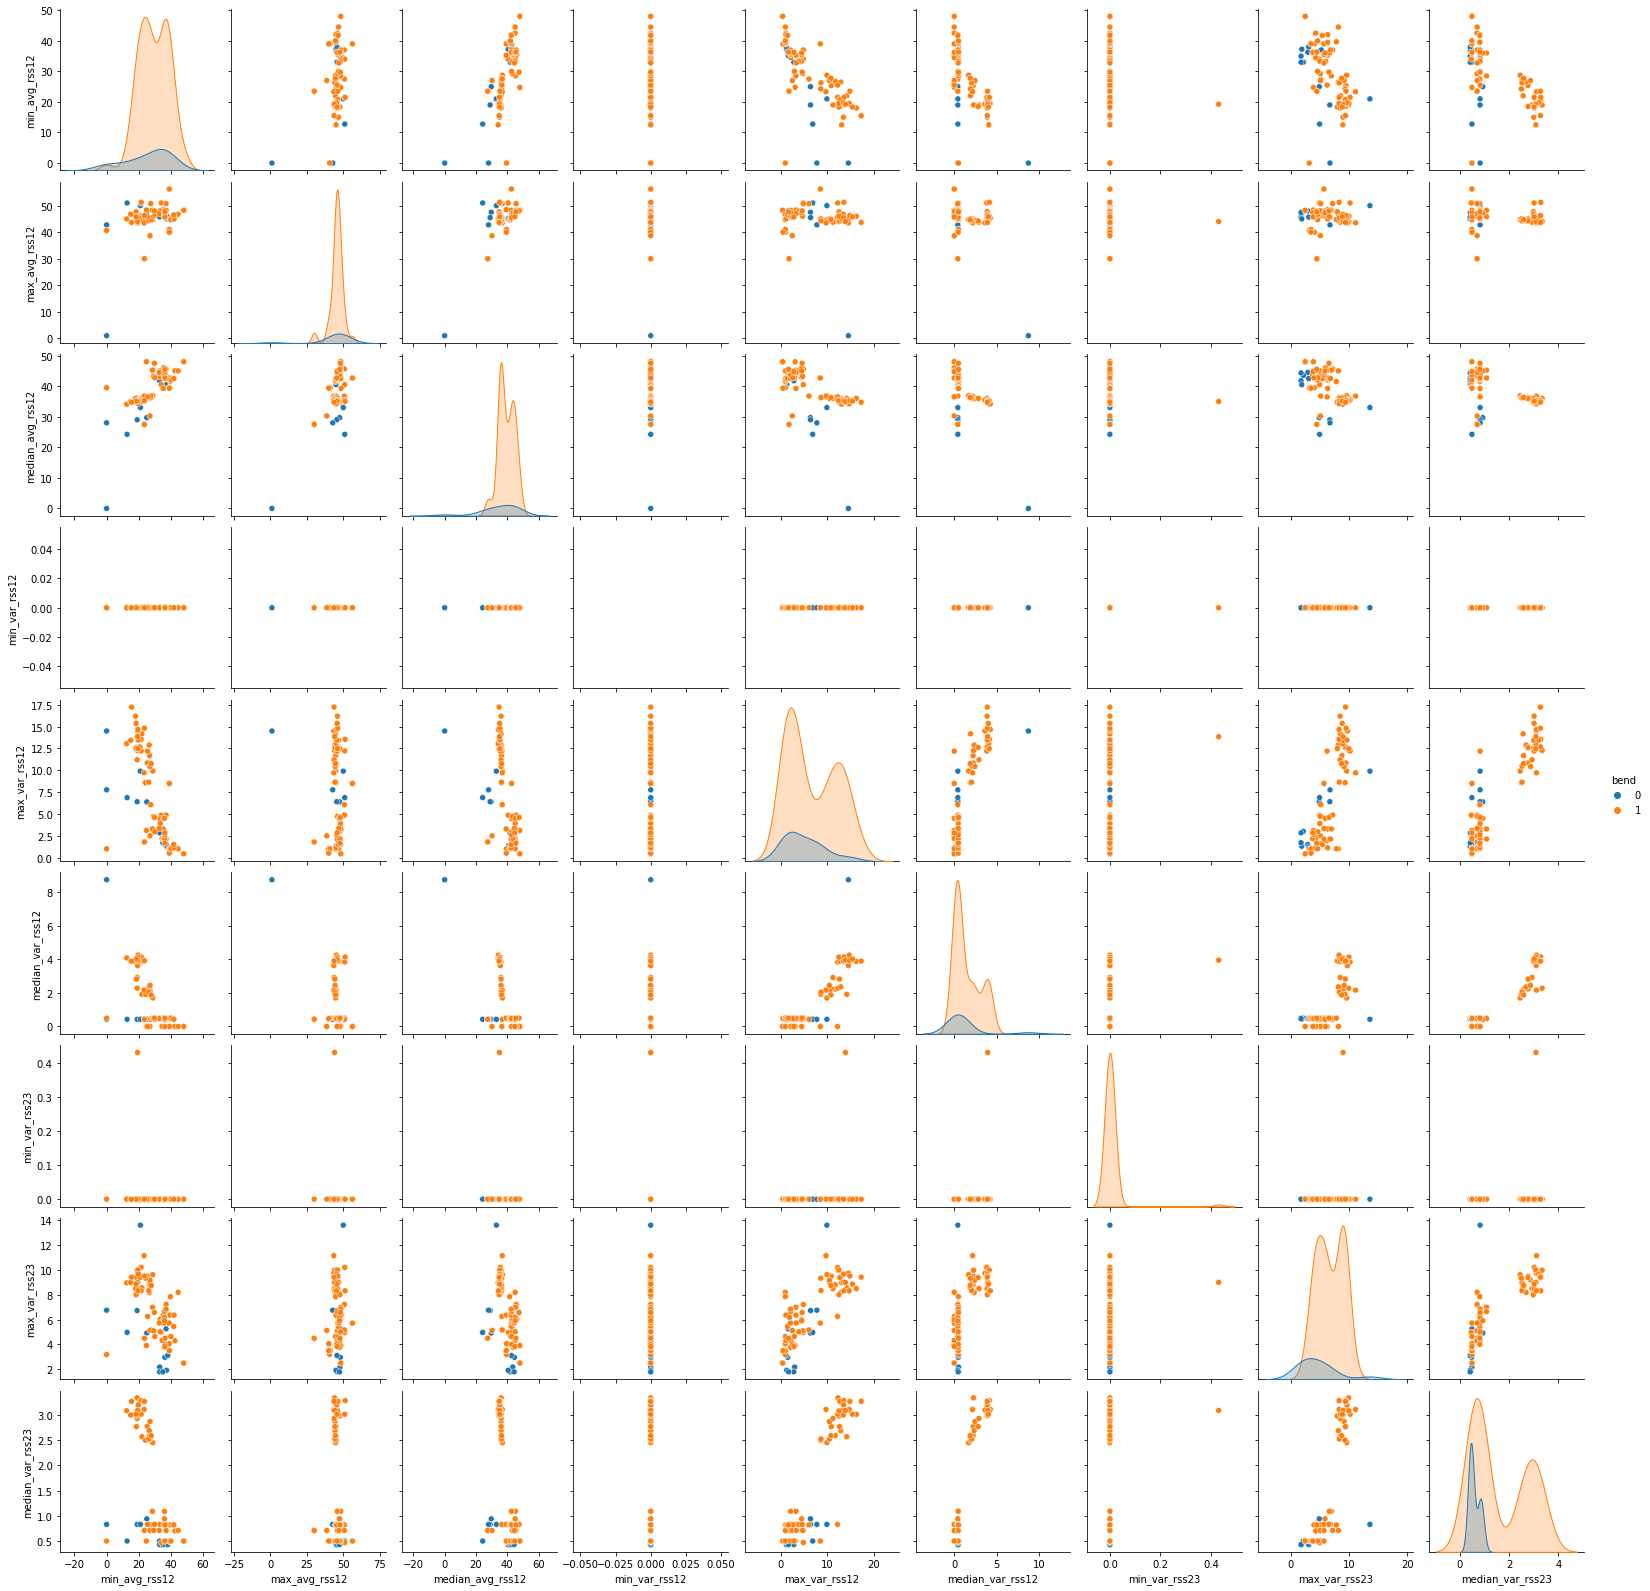

In [11]:
sns.pairplot(feat_scatter,hue='bend')

ii. Break each time series in your training set into two (approximately) equal length time series. 
Now instead of 6 time series for each of the training instances, you have 12 time series for 
each training instance. Repeat the experiment in 1(d)i, i.e depict scatter plots of the features extracted
from both parts of the time series 1,2, and 12. Do you see any considerable difference in the results with
those of 1(d)i?

In [12]:
new_data = {}
for i, j in data_hw3.items():
    if i == 'sittingdataset8.csv':
        avg_rss12 = j['avg_rss12'][0:239]
        avg_rss12_2 = j['avg_rss12'][240:]
        var_rss12 = j['var_rss12'][0:239]
        var_rss12_2 = j['var_rss12'][240:]
        avg_rss13 = j['avg_rss13'][0:239]
        avg_rss13_2 = j['avg_rss13'][240:]
        var_rss13 = j['var_rss13'][0:239]
        var_rss13_2 = j['var_rss13'][240:]
        avg_rss23 = j['avg_rss23'][0:239]
        avg_rss23_2 = j['avg_rss23'][240:]
        var_rss23 = j['var_rss23'][0:239]
        var_rss23_2 = j['var_rss23'][240:]
    else:
        avg_rss12 = j['avg_rss12'][0:240]
        avg_rss12_2 = j['avg_rss12'][240:]
        var_rss12 = j['var_rss12'][0:240]
        var_rss12_2 = j['var_rss12'][240:]
        avg_rss13 = j['avg_rss13'][0:240]
        avg_rss13_2 = j['avg_rss13'][240:]
        var_rss13 = j['var_rss13'][0:240]
        var_rss13_2 = j['var_rss13'][240:]
        avg_rss23 = j['avg_rss23'][0:240]
        avg_rss23_2 = j['avg_rss23'][240:]
        var_rss23 = j['var_rss23'][0:240]
        var_rss23_2 = j['var_rss23'][240:]
    update = pd.DataFrame(
        {
            'avg_rss12':list(avg_rss12),
            'avg_rss12_2':list(avg_rss12_2),
            'var_rss12':list(var_rss12),
            'var_rss12_2':list(var_rss12_2),
            'avg_rss13':list(avg_rss13),
            'avg_rss13_2':list(avg_rss13_2),
            'var_rss13':list(var_rss13),
            'var_rss13_2':list(var_rss13_2),
            'avg_rss23':list(avg_rss23),
            'avg_rss23_2':list(avg_rss23_2),
            'var_rss23':list(var_rss23),
            'var_rss23_2':list(var_rss23_2)
        }
    )
    new_data[i]= update
new_data['sittingdataset8.csv']

,avg_rss12,avg_rss12_2,var_rss12,var_rss12_2,avg_rss13,avg_rss13_2,var_rss13,var_rss13_2,avg_rss23,avg_rss23_2,var_rss23,var_rss23_2
0,44.00,42.50,0.71,0.50,18.75,21.00,0.43,0.00,7.75,15.75,1.30,0.83
1,44.00,42.25,0.00,0.43,18.50,21.00,0.50,0.00,8.67,15.25,0.47,0.43
2,43.75,42.50,0.83,0.50,18.00,20.75,0.00,0.43,9.67,16.00,0.94,0.71
3,43.75,42.00,0.43,0.00,18.25,19.00,0.43,0.71,9.00,14.25,0.00,0.83
4,43.75,42.25,0.43,0.43,18.00,18.00,0.00,0.00,9.00,12.25,0.00,0.43
...,...,...,...,...,...,...,...,...,...,...,...,...
234,43.33,42.25,0.47,0.43,18.00,18.00,0.00,0.00,17.33,16.50,0.47,1.12
235,43.00,42.00,0.89,0.00,18.00,18.00,0.00,0.00,16.60,16.00,0.80,0.82
236,43.00,42.50,0.82,0.50,20.00,18.00,0.71,0.00,18.00,15.25,0.00,0.43
237,43.00,42.50,1.00,0.50,20.00,18.25,0.00,0.43,17.25,16.00,1.30,1.22


In [13]:
a = new_data.values()
a = list(a)
#print(a)
instance = []
var = ['avg_rss12', 'avg_rss12_2','var_rss12', 'var_rss12_2', 'avg_rss13', 
       'avg_rss13_2','var_rss13', 'var_rss13_2','avg_rss23', 'avg_rss23_2','var_rss23','var_rss23_2']
for i in range(0,88,1):
    number = []
    name = []
    k = 1
    for j in var:
        mini = min(a[i][j])
        maxi = max(a[i][j])
        mean = stat.mean(a[i][j])
        median = stat.median(a[i][j])
        sd = a[i][j].std()
        first = a[i][j].quantile(0.25)
        third = a[i][j].quantile(0.75)
        number.append(mini)
        number.append(maxi)
        number.append(mean)
        number.append(median)
        number.append(sd)
        number.append(first)
        number.append(third)
        name.append("min_" + j)
        name.append("max_"+ j)
        name.append("mean_" + j)
        name.append("median_"+ j)
        name.append("Sta_Dev_"+ j)
        name.append("1_quart_"+ j)
        name.append("3_quart_"+ j)
        k = k + 1
    instance.append(number)
inst_total = pd.DataFrame(instance,columns=name)
inst_total

,min_avg_rss12,max_avg_rss12,mean_avg_rss12,median_avg_rss12,Sta_Dev_avg_rss12,1_quart_avg_rss12,3_quart_avg_rss12,min_avg_rss12_2,max_avg_rss12_2,mean_avg_rss12_2,...,Sta_Dev_var_rss23,1_quart_var_rss23,3_quart_var_rss23,min_var_rss23_2,max_var_rss23_2,mean_var_rss23_2,median_var_rss23_2,Sta_Dev_var_rss23_2,1_quart_var_rss23_2,3_quart_var_rss23_2
0,36.67,45.00,43.486208,43.710,1.281976,42.3300,44.5000,36.25,48.00,44.452042,...,0.486847,0.00,0.8300,0.00,2.96,0.585750,0.500,0.487918,0.4225,0.8300
1,39.00,48.00,44.117042,45.000,1.359836,43.5000,45.0000,37.00,46.50,42.792875,...,0.718016,0.43,1.1200,0.00,4.06,0.543875,0.500,0.473445,0.4300,0.7100
2,33.75,47.75,43.278875,45.000,3.473355,42.0000,45.2500,33.00,46.00,41.080750,...,0.554542,0.00,1.2200,0.00,2.18,0.586083,0.470,0.491873,0.0000,0.8700
3,33.00,45.75,41.621208,42.330,3.118644,39.6525,44.2500,39.25,43.67,41.734917,...,0.411200,0.00,0.7100,0.00,1.50,0.347500,0.430,0.363144,0.0000,0.5000
4,38.00,42.33,40.946958,41.250,1.102963,40.3100,42.0000,37.25,45.00,40.302625,...,0.647856,0.00,1.3000,0.00,1.92,0.552167,0.430,0.510494,0.0000,0.9400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,20.33,44.50,34.036750,34.415,4.872880,30.7500,37.7500,19.75,45.50,34.608750,...,1.703098,2.28,4.7900,0.00,9.67,3.321417,3.155,1.758379,2.0500,4.3950
84,19.25,44.00,34.916792,35.375,4.634209,31.7500,38.2500,20.75,43.33,34.029583,...,1.737420,2.15,4.5075,0.43,8.26,3.241000,3.060,1.657578,2.1200,4.3050
85,24.33,44.00,34.920792,35.330,4.272282,32.2500,37.8125,23.50,46.25,34.825667,...,1.781928,2.16,4.5850,0.00,9.51,3.418667,3.350,1.598536,2.1700,4.4525
86,18.33,44.00,34.836458,35.750,4.869092,32.0000,38.6900,22.67,45.75,34.363292,...,1.647640,2.06,4.1200,0.47,8.84,3.409458,3.110,1.707089,2.1700,4.3450


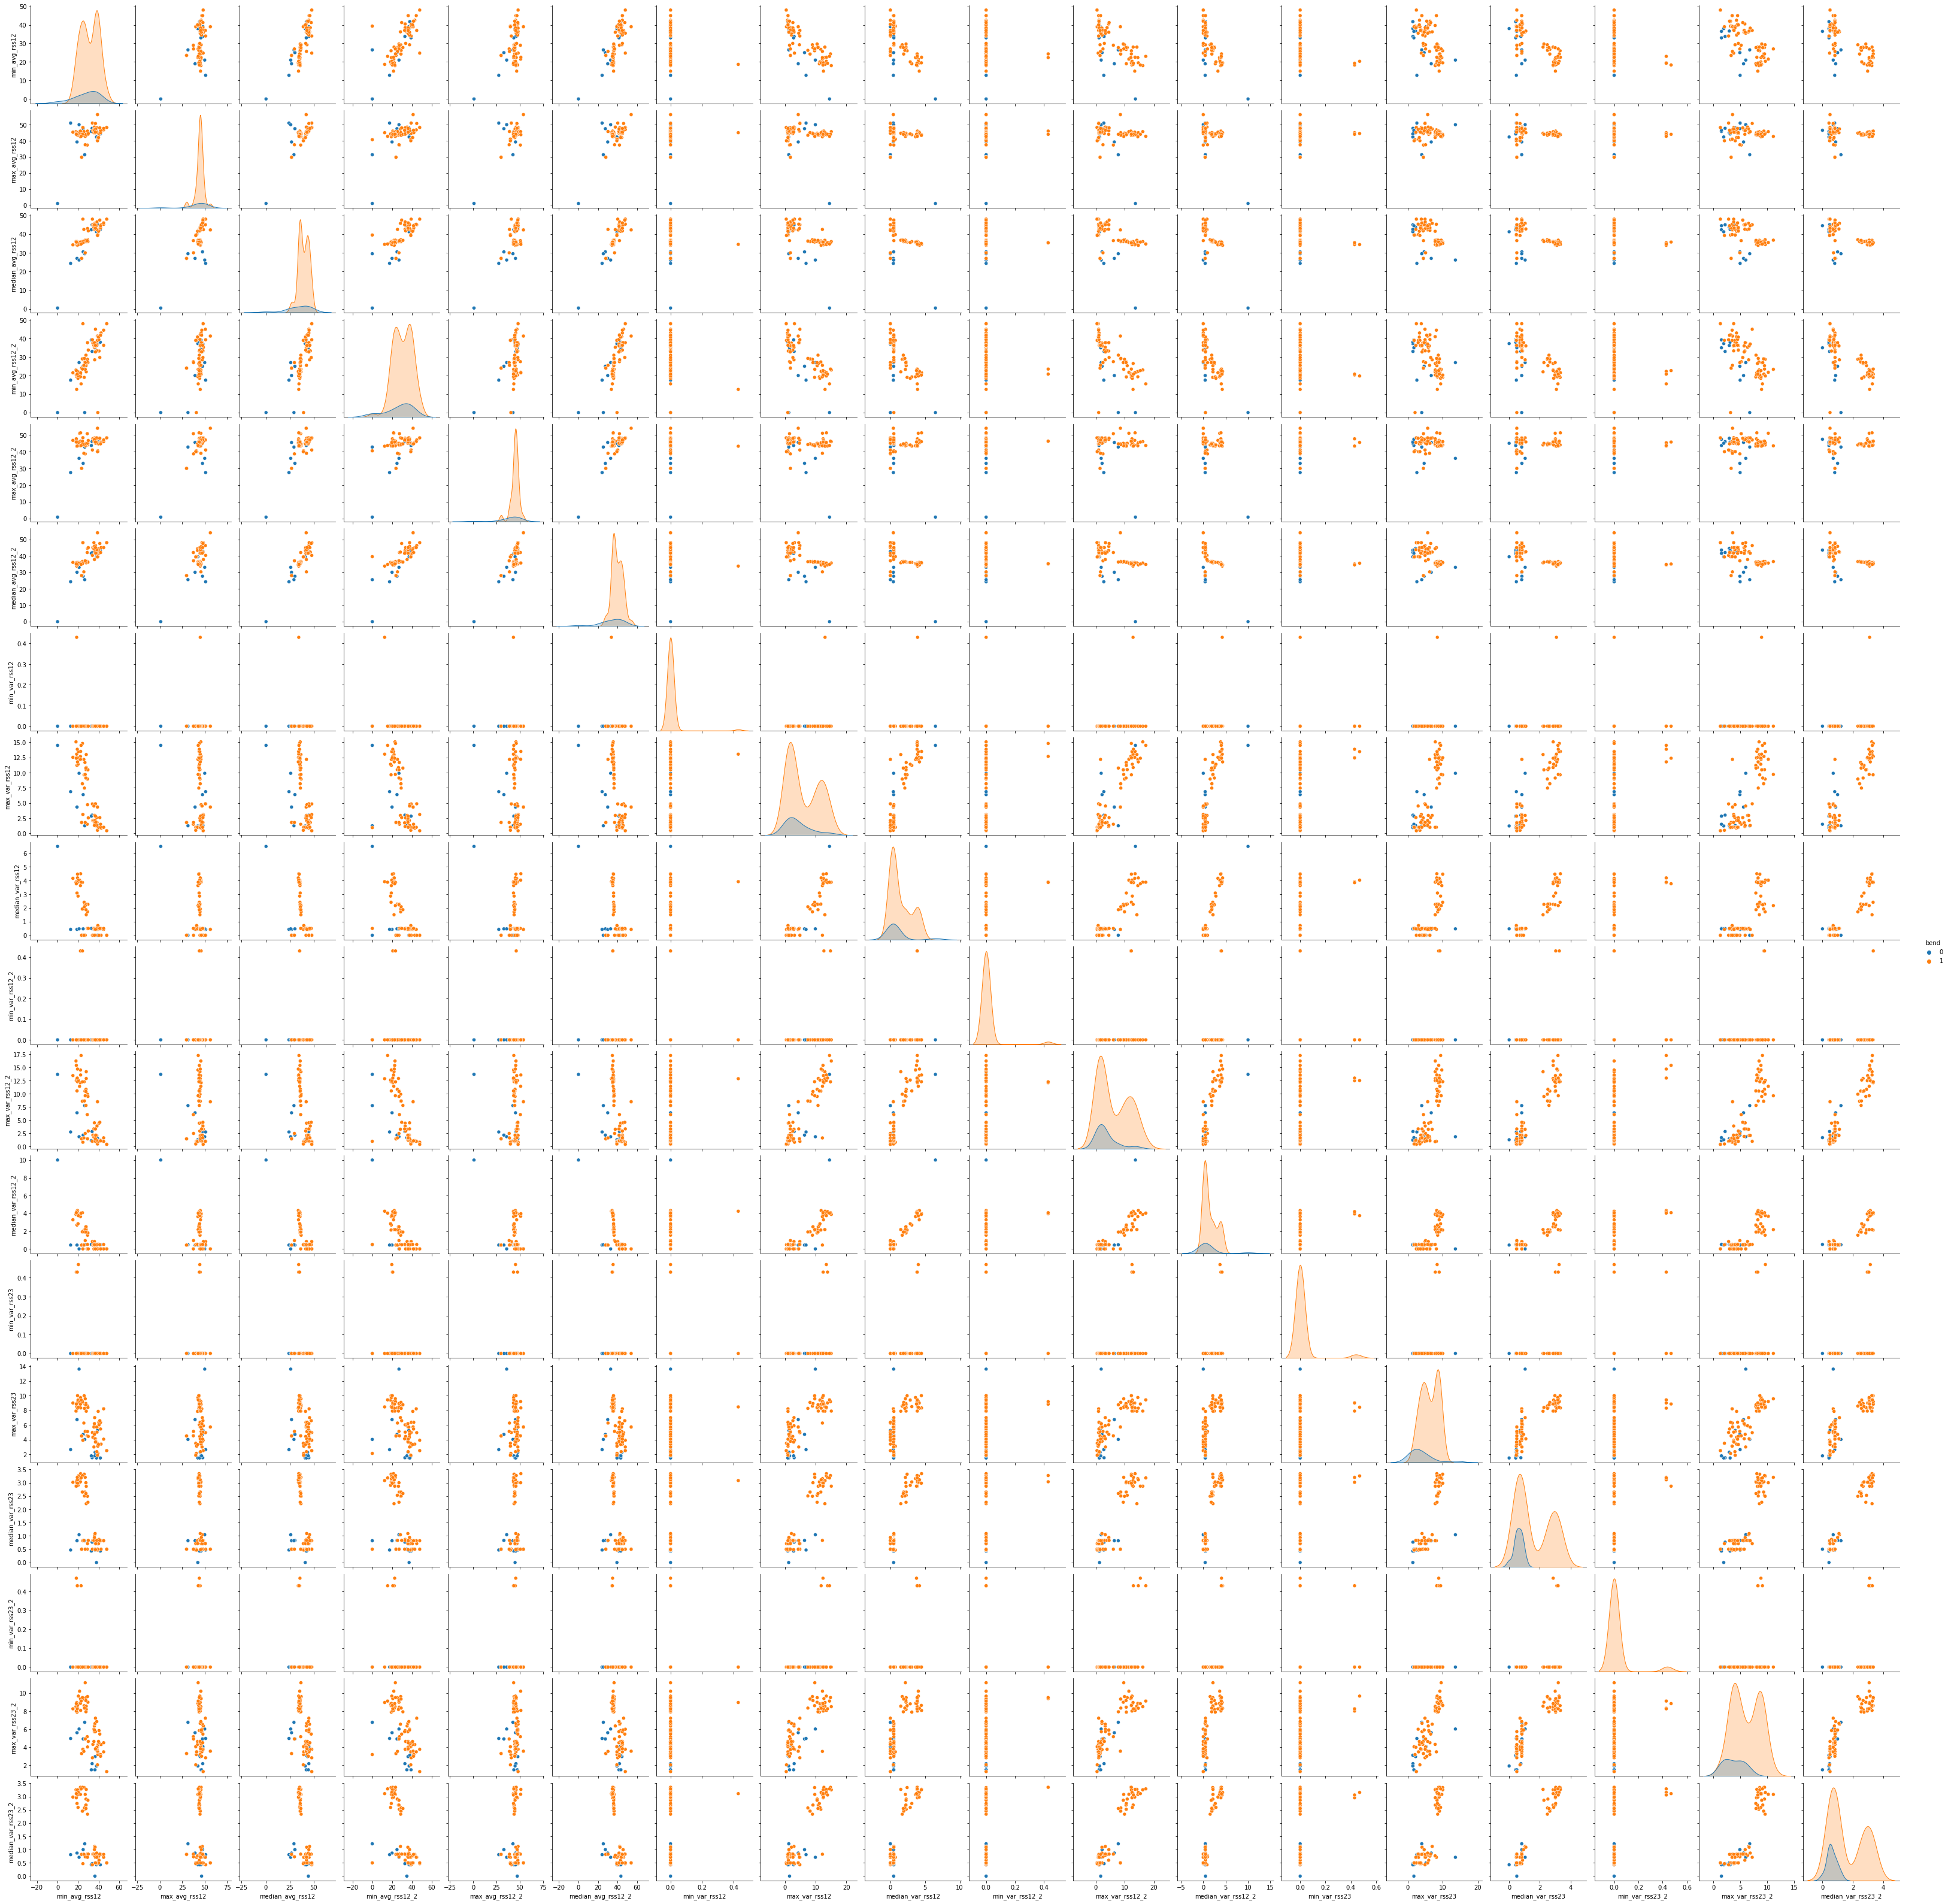

In [14]:
feat_scatter = inst_total[['min_avg_rss12','max_avg_rss12','median_avg_rss12',
                           'min_avg_rss12_2','max_avg_rss12_2','median_avg_rss12_2',
                           'min_var_rss12','max_var_rss12','median_var_rss12',
                           'min_var_rss12_2','max_var_rss12_2','median_var_rss12_2',
                          'min_var_rss23','max_var_rss23','median_var_rss23',
                          'min_var_rss23_2','max_var_rss23_2','median_var_rss23_2',]]
feat_scatter['bend'] = [0]* 13 + [1] * 75 # bending has 13 datasets
feat_scatter
sns.pairplot(feat_scatter,hue='bend')

There is no big difference between i and ii.

iii.

In [15]:
test_update = {}
test_divide = list(test_data.values())

for i in range(1,21,1):
    record = []
    for j in test_divide:
        j = j.drop(['time'],axis=1)
        df_data = pd.DataFrame()
        dt = np.array_split(j,i)
        #print(dt)
        for ind, k in enumerate(dt):
            k.reset_index(drop=True, inplace=True)
            #print(ind)
            for a in k.columns:   #a=avr_rss12...
                b = ind + 1
                df_data[a+'_'+str(b)] = k[a]
        #print(df_data)
        number = []
        name = []
        for index, c in enumerate(df_data.columns):
            mini = min(df_data[c])
            maxi = max(df_data[c])
            #mean = stat.mean(df_data[c])
            median = stat.median(df_data[c])
            #sd = df_data[c].std()
            #first = df_data[c].quantile(0.25)
            #third = df_data[c].quantile(0.75)
            number.append(mini)
            number.append(maxi)
            #number.append(mean)
            number.append(median)
            #number.append(sd)
            #number.append(first)
            #number.append(third)
            name.append("min_" + c)
            name.append("max_"+ c)
            #name.append("mean_" + c)
            name.append("median_"+ c)
            #name.append("Sta_Dev_"+ c)
            #name.append("1_quart_"+ c)
            #name.append("3_quart_"+ c)
        record.append(number)
    df_data_new = pd.DataFrame(record, columns=name)
    df_data_new['bend'] = [0]* 4 +[1] * 15
    test_update[i] = df_data_new
print(test_update)

{1:     min_avg_rss12_1  max_avg_rss12_1  median_avg_rss12_1  min_var_rss12_1  \
0             37.25            45.00              40.500              0.0   
1             38.00            45.67              42.500              0.0   
2             12.75            51.00              24.250              0.0   
3              0.00            42.75              28.000              0.0   
4             24.25            45.00              36.250              0.0   
5             28.75            44.75              36.875              0.0   
6             22.00            44.67              36.000              0.0   
7             23.50            30.00              27.500              0.0   
8             24.75            48.33              48.000              0.0   
9             48.00            48.25              48.000              0.0   
10            33.25            48.00              43.000              0.0   
11            37.00            50.75              45.635              0.

In [16]:
train_update = {}
train_divide = list(train_data.values())
#print(list(enumerate(test_divide)))
#for a,k in enumerate(test_divide):
    #print(a)      19 datasets
    #k_new = k.drop(['time'],axis=1)  #index is 6 features.
    #df_data = pd.DataFrame()
    #sep_col[a] = k_new#np.array_split(j_new,1)
#print(sep_col)
#print(sep_col)
for i in range(1,21,1):
    record = []
    sep_col={}
    for j in train_divide:
        j = j.drop(['time'],axis=1)
        df_data = pd.DataFrame()
        dt = np.array_split(j,i)
        for ind, k in enumerate(dt):
            k.reset_index(drop=True,inplace=True)
            #sese = list(sep_col.values()) 
            #k_new = sese[ind]
            for a in k.columns:
                b = ind + 1
                df_data[a+'_'+str(b)] = k[a]
        number = []
        name = []
        for index, c in enumerate(df_data.columns):
            mini = min(df_data[c])
            maxi = max(df_data[c])
            #mean = stat.mean(df_data[c])
            median = stat.median(df_data[c])
            #sd = df_data[c].std()
            #first = df_data[c].quantile(0.25)
            #third = df_data[c].quantile(0.75)
            number.append(mini)
            number.append(maxi)
            #number.append(mean)
            number.append(median)
            #number.append(sd)
            #number.append(first)
            #number.append(third)
            name.append("min_" + c)
            name.append("max_"+ c)
            #name.append("mean_" + c)
            name.append("median_"+ c)
            #name.append("Sta_Dev_"+ c)
            #name.append("1_quart_"+ c)
            #name.append("3_quart_"+ c)
        record.append(number)
    df_data_new = pd.DataFrame(record, columns=name)
    df_data_new['bend'] = [0]* 9 +[1] * 60
    train_update[i] = df_data_new
print(train_update)

{1:     min_avg_rss12_1  max_avg_rss12_1  median_avg_rss12_1  min_var_rss12_1  \
0             36.25            48.00              44.500              0.0   
1             37.00            48.00              43.250              0.0   
2             33.00            47.75              43.500              0.0   
3             33.00            45.75              41.750              0.0   
4             35.00            47.40              44.330              0.0   
..              ...              ...                 ...              ...   
64            19.75            45.50              35.250              0.0   
65            19.25            44.00              35.000              0.0   
66            23.50            46.25              35.250              0.0   
67            18.33            45.75              35.125              0.0   
68            15.50            43.67              34.750              0.0   

    max_var_rss12_1  median_var_rss12_1  min_avg_rss13_1  max_avg_rss13

In [17]:
for a, b in test_update.items():
    b.fillna(0, inplace=True)
for c, d in train_update.items():
    #print(d.iloc[43])
    d.fillna(np.mean(d.iloc[43]), inplace=True)

In [18]:
print(train_update)

{1:     min_avg_rss12_1  max_avg_rss12_1  median_avg_rss12_1  min_var_rss12_1  \
0             36.25            48.00              44.500              0.0   
1             37.00            48.00              43.250              0.0   
2             33.00            47.75              43.500              0.0   
3             33.00            45.75              41.750              0.0   
4             35.00            47.40              44.330              0.0   
..              ...              ...                 ...              ...   
64            19.75            45.50              35.250              0.0   
65            19.25            44.00              35.000              0.0   
66            23.50            46.25              35.250              0.0   
67            18.33            45.75              35.125              0.0   
68            15.50            43.67              34.750              0.0   

    max_var_rss12_1  median_var_rss12_1  min_avg_rss13_1  max_avg_rss13

The right way is to use stratified cross validation because it has time series features.
K-fold is a wrong way because it doesn't have time features.

In [19]:
dt_name={}
accuracy = {}
#rfe =RFE(model, 3)
for a in range(1,21,1):
    model_lr = LogisticRegression()
    x_train = train_update[a].drop(['bend'],axis=1)
    y_train = train_update[a]['bend']
    rfecv = RFECV(estimator=model_lr, cv=StratifiedKFold(5),scoring='accuracy').fit(x_train,y_train)
    accuracy[a] = rfecv.grid_scores_[rfecv.n_features_-1]
    print("RFECV final number of features : %d" % rfecv.n_features_)
    name = []
    for ind, b in enumerate(x_train.columns):
        if rfecv.support_[ind] == True:
            name.append(b)
    dt_name[a] = name

RFECV final number of features : 12
RFECV final number of features : 7
RFECV final number of features : 2
RFECV final number of features : 26
RFECV final number of features : 4
RFECV final number of features : 6
RFECV final number of features : 2
RFECV final number of features : 8
RFECV final number of features : 1
RFECV final number of features : 1
RFECV final number of features : 3
RFECV final number of features : 12
RFECV final number of features : 1
RFECV final number of features : 1
RFECV final number of features : 7
RFECV final number of features : 19
RFECV final number of features : 1
RFECV final number of features : 7
RFECV final number of features : 5
RFECV final number of features : 8


In [20]:
print(accuracy)

{1: 0.9571428571428571, 2: 0.9428571428571428, 3: 0.9428571428571428, 4: 0.9428571428571428, 5: 0.9142857142857143, 6: 0.9428571428571428, 7: 0.9571428571428573, 8: 0.9285714285714285, 9: 0.9571428571428573, 10: 0.9571428571428573, 11: 0.9428571428571428, 12: 0.9428571428571428, 13: 0.956043956043956, 14: 0.956043956043956, 15: 0.9428571428571428, 16: 0.9428571428571428, 17: 0.9428571428571428, 18: 0.9428571428571428, 19: 0.9428571428571428, 20: 0.9428571428571428}


In [21]:
lst = []
for a, b in accuracy.items():
    lst.append(b)
print(lst)
print('\n')
maxi = lst.index(max(lst))
print(maxi, str(lst[maxi]))

[0.9571428571428571, 0.9428571428571428, 0.9428571428571428, 0.9428571428571428, 0.9142857142857143, 0.9428571428571428, 0.9571428571428573, 0.9285714285714285, 0.9571428571428573, 0.9571428571428573, 0.9428571428571428, 0.9428571428571428, 0.956043956043956, 0.956043956043956, 0.9428571428571428, 0.9428571428571428, 0.9428571428571428, 0.9428571428571428, 0.9428571428571428, 0.9428571428571428]


6 0.9571428571428573


In [22]:
dt_name[maxi]

['max_avg_rss12_1',
 'min_avg_rss13_1',
 'max_avg_rss23_1',
 'median_avg_rss23_1',
 'median_avg_rss12_4',
 'min_avg_rss23_4']

So (l,p) in my case will be (6,6)

iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. 
Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

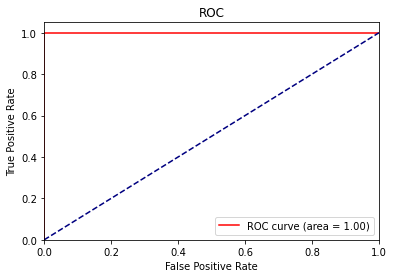

[[ 9  0]
 [ 0 60]]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.41979908645238e-11
            Iterations: 36
            Function evaluations: 43
            Gradient evaluations: 36
max_avg_rss12_1       0.999768
min_avg_rss13_1       0.999884
max_avg_rss23_1       0.999799
median_avg_rss23_1    0.999987
median_avg_rss12_4    0.999805
min_avg_rss23_4       0.999945
dtype: float64


In [23]:

x_train = train_update[maxi][dt_name[maxi]]
y_train = train_update[maxi]['bend']
x_test = test_update[maxi][dt_name[maxi]]
y_test = test_update[maxi]['bend']

lrlr = LogisticRegression()
lrlr.fit(x_train,y_train)

y_pred = lrlr.predict(x_train)
fpr, tpr, _= roc_curve(y_train,y_pred)
ro_au = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' %ro_au)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

arr = confusion_matrix(y_train, y_pred)
print(arr)

logreg = sm.Logit(y_train,x_train).fit_regularized()
print(logreg.pvalues)

V. Test the classifier on the test set.

In [24]:
lrlr2 = LogisticRegression()
lrlr2.fit(x_train,y_train)
print(lrlr2.score(x_test,y_test))

0.9473684210526315


Vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes

vii. From the confusion matrices you obtained, do you see imbalanced classes?

Yes

vii.build a logistic regression model based on case-control sampling and adjust its parameters

<class 'pandas.core.frame.DataFrame'>


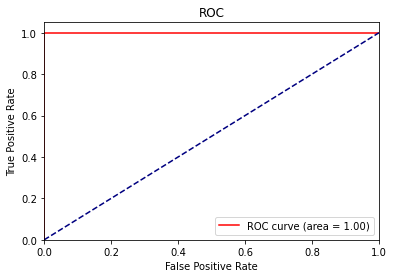

[[60  0]
 [ 0 60]]


In [25]:
dataset = train_update[maxi][dt_name[maxi]]
dataset['bend'] = [0] * 9 + [1] * 60

small_part = dataset[dataset['bend'] == 0]
print(type(small_part))
more_sample = resample(small_part,n_samples=60)
large_part = dataset[dataset['bend'] == 1]
df_total = pd.concat([large_part, more_sample])
df_total
y_train_new = df_total['bend']
x_train_new = df_total.drop('bend',axis=1)
lrlr3 = LogisticRegression()
lrlr3.fit(x_train_new, y_train_new)
y_pred_new = lrlr3.predict(x_train_new)

fpr, tpr, _= roc_curve(y_train_new,y_pred_new)
ro_au = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' %ro_au)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

arr = confusion_matrix(y_train_new, y_pred_new)
print(arr)

(e)i. Repeat 1(d)iii using L1-penalized logistic regression

In [26]:
accuracy = {}
for a in range(1,21,1):
    lrcv = LogisticRegression(penalty='l1',solver='liblinear')
    x_train = train_update[a].drop(['bend'],axis=1)
    y_train = train_update[a]['bend']
    lrcv.fit(x_train,y_train)
    scor = lrcv.score(x_train,y_train)
    accuracy[a] = scor
print(accuracy)

{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 20: 1.0}


(e)ii. Compare the L1-penalized with variable selection using p-values. Which one
performs better

Comparing these two accuracy dictionaries,
I think L1-penalized logistic regression is better and easier to implement.

(f)i. find the best l in the same way as you found it in 1(e)i to build an L1 penalized multinomial regression model
to classify all activities in your training set

In [27]:
error = {}
for a in range(1,21,1):
    x_test = test_update[a].drop(['bend'],axis=1)
    y_med_t = test_update[a]['bend']
    y_med_t['multicla'] = [0]*4+[1]*5+[2]*5+[3]*5
    y_test = y_med_t['multicla']
    
    x_train = train_update[a].drop(['bend'],axis=1)
    y_med = train_update[a]['bend']
    y_med['multicla'] = [0]*9+[1]*20+[2]*20+[3]*20
    y_train = y_med['multicla']
    
    lrcv = LogisticRegression(penalty='l1',solver='liblinear')
    lrcv.fit(x_train,y_train)
    scor = 1 - lrcv.score(x_train,y_train)
    error[a] = scor
print(error)
lst = []
for a, b in error.items():
    lst.append(b)
print(lst)
print('\n')
mini = lst.index(min(lst))
print('optimal l and pair:')
print(mini, str(lst[mini]))

{1: 0.14492753623188404, 2: 0.04347826086956519, 3: 0.01449275362318836, 4: 0.01449275362318836, 5: 0.01449275362318836, 6: 0.01449275362318836, 7: 0.01449275362318836, 8: 0.01449275362318836, 9: 0.01449275362318836, 10: 0.01449275362318836, 11: 0.01449275362318836, 12: 0.01449275362318836, 13: 0.01449275362318836, 14: 0.01449275362318836, 15: 0.01449275362318836, 16: 0.01449275362318836, 17: 0.01449275362318836, 18: 0.01449275362318836, 19: 0.01449275362318836, 20: 0.01449275362318836}
[0.14492753623188404, 0.04347826086956519, 0.01449275362318836, 0.01449275362318836, 0.01449275362318836, 0.01449275362318836, 0.01449275362318836, 0.01449275362318836, 0.01449275362318836, 0.01449275362318836, 0.01449275362318836, 0.01449275362318836, 0.01449275362318836, 0.01449275362318836, 0.01449275362318836, 0.01449275362318836, 0.01449275362318836, 0.01449275362318836, 0.01449275362318836, 0.01449275362318836]


optimal l and pair:
2 0.01449275362318836


In [28]:
x_test = test_update[mini].drop(['bend'],axis=1)
y_med_t = test_update[mini]['bend']
y_med_t['multicla'] = [0]*4+[1]*5+[2]*5+[3]*5
y_test = y_med_t['multicla']
    
x_train = train_update[mini].drop(['bend'],axis=1)
y_med = train_update[mini]['bend']
y_med['multicla'] = [0]*9+[1]*20+[2]*20+[3]*20
y_train = y_med['multicla']

lrcv_2 = LogisticRegression(penalty='l1',solver='liblinear')
lrcv_2.fit(x_train,y_train)
y_pred = lrcv_2.predict(x_test)
confusion_matrix(y_test,y_pred)

array([[4, 0, 0, 0],
       [0, 4, 1, 0],
       [0, 1, 4, 0],
       [0, 0, 1, 4]])

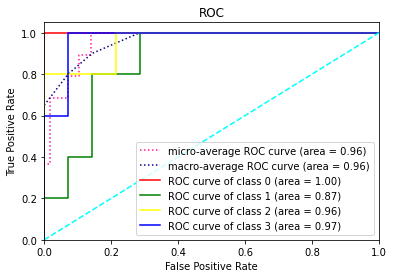

In [29]:
x_train = train_update[mini].drop(['bend'],axis=1)
y_med = train_update[mini]['bend']
y_med['multicla'] = [0]*9+[1]*20+[2]*20+[3]*20
y_train = y_med['multicla']
y_train_bi = label_binarize(y_train,classes = [0,1,2,3])
n = y_train_bi.shape[1]

x_test = test_update[mini].drop(['bend'],axis=1)
y_med_t = test_update[mini]['bend']
y_med_t['multicla'] = [0]*4+[1]*5+[2]*5+[3]*5
y_test = y_med_t['multicla']
y_test_bi = label_binarize(y_test,classes = [0,1,2,3])

fpr = dict()
tpr = dict()
ro_au = dict()

classtype = OneVsRestClassifier(LogisticRegression(penalty='l1', solver='liblinear'))
fitting = classtype.fit(x_train,y_train_bi).decision_function(x_test)

for a in range(n):
    fpr[a], tpr[a], _ = roc_curve(y_test_bi[:, a], fitting[:, a])
    ro_au[a] = auc(fpr[a], tpr[a])

fpr['micro'], tpr['micro'], _ = roc_curve(y_test_bi.ravel(), fitting.ravel())
ro_au['micro'] = auc(fpr['micro'], tpr['micro'])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
ro_au['macro'] = auc(fpr['macro'], tpr['macro'])

plt.figure()
plt.plot(fpr['micro'], tpr['micro'],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(ro_au['micro']),
         color='deeppink', linestyle=':')

plt.plot(fpr['macro'], tpr['macro'],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(ro_au['macro']),
         color='navy', linestyle=':')
colors = cycle(['red', 'green', 'yellow', 'blue'])
for i, color in zip(range(n), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, ro_au[i]))
plt.plot([0, 1], [0, 1], color='aqua', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

(f)ii. Repeat 1(f)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multi- nomial priors and compare the results.

In [30]:
accuracy = {}
for a in range(1,21,1):
    x_train = train_update[a].drop(['bend'],axis=1)
    y_med = train_update[a]['bend']
    y_med['multicla'] = [0]*9+[1]*20+[2]*20+[3]*20
    y_train = y_med['multicla']
    
    gau = GaussianNB()
    gau.fit(x_train,y_train)
    #scor = gau.score(x_train,y_train)
    scor = cross_val_score(gau,x_train,y_train,cv=3)
    accuracy[a] = scor
#print(accuracy)
mamama=[]
for b,c in accuracy.items():
    mamax = max(c)
    mamama.append(mamax)
print(mamama)
print(stat.mean(mamama))


[0.6521739130434783, 0.6086956521739131, 0.6086956521739131, 0.5652173913043478, 0.6086956521739131, 0.6086956521739131, 0.5217391304347826, 0.4782608695652174, 0.5652173913043478, 0.4782608695652174, 0.43478260869565216, 0.43478260869565216, 0.391304347826087, 0.43478260869565216, 0.43478260869565216, 0.391304347826087, 0.391304347826087, 0.391304347826087, 0.391304347826087, 0.34782608695652173]
0.48695652173913045


In [31]:
accuracy = {}
for a in range(1,21,1):
    x_train = train_update[a].drop(['bend'],axis=1)
    y_med = train_update[a]['bend']
    y_med['multicla'] = [0]*9+[1]*20+[2]*20+[3]*20
    y_train = y_med['multicla']
    
    mul = MultinomialNB()
    #mul.fit(x_train,y_train)
    #scor = mul.score(x_train,y_train)
    scor = cross_val_score(mul,x_train,y_train)
    accuracy[a] = scor
#print(accuracy)
mamama=[]
for b,c in accuracy.items():
    mamax = max(c)
    mamama.append(mamax)
print(mamama)
print(stat.mean(mamama))

[0.7142857142857143, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714]
0.6357142857142858


(f)iii. Multinomial classifier is better for multi-class classification in this problem.

# ISLR 3.7.4

(a) The residual sum of squares will be less because equation with cubic term might be fit more to data.

(b) It will have higher RSS because the cubic term might overfit the model.

(c) Since the true relationship is not linear, the linear regression training is not suitable. 
In this case, the cubic equation might have lower RSS and be better to train.

(d) As for the test RSS, we don't have enough information. If the linear regression is close to data, then lower RSS. If the cubic regression is close to data, then lower RSS. 

# ISLR 4.8.3

# ISLR 4.8.7

The answer is 0.752. The process is in notebook folder.

related websites: https://stats.stackexchange.com/questions/50807/features-for-time-series-classification

sort: https://realpython.com/pandas-sort-python/
https://machinelearningmastery.com/rfe-feature-selection-in-python/ 
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/
https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
https://python.hotexamples.com/zh/examples/sklearn.naive_bayes/GaussianNB/score/python-gaussiannb-score-method-examples.html